In [1]:
from keras.datasets import mnist

Using TensorFlow backend.
C:\Users\uSer\AnacondaMy\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\uSer\AnacondaMy\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\uSer\AnacondaMy\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\uSer\AnacondaMy\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as p3
import numpy as np
import random
import time

from functools import partial
from ipywidgets import interact, RadioButtons, IntSlider, FloatSlider, Dropdown, BoundedFloatText
from numpy.linalg import norm

In [4]:
def sigmoid(x):
    """сигмоидальная функция, работает и с числами, и с векторами (поэлементно)"""
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    """производная сигмоидальной функции, работает и с числами, и с векторами (поэлементно)"""
    return sigmoid(x) * (1 - sigmoid(x))

In [5]:
def J_quadratic(neuron, X, y):
    """
    Оценивает значение квадратичной целевой функции.
    Всё как в лекции, никаких хитростей.

    neuron - нейрон, у которого есть метод vectorized_forward_pass, предсказывающий значения на выборке X
    X - матрица входных активаций (n, m)
    y - вектор правильных ответов (n, 1)
        
    Возвращает значение J (число)
    """
    
    assert y.shape[1] == 1, 'Incorrect y shape'
    
    return 0.5 * np.mean((neuron.vectorized_forward_pass(X) - y) ** 2)

def J_quadratic_derivative(y, y_hat):
    """
    Вычисляет вектор частных производных целевой функции по каждому из предсказаний.
    y_hat - вертикальный вектор предсказаний,
    y - вертикальный вектор правильных ответов,
    
    В данном случае функция смехотворно простая, но если мы захотим поэкспериментировать 
    с целевыми функциями - полезно вынести эти вычисления в отдельный этап.
    
    Возвращает вектор значений производной целевой функции для каждого примера отдельно.
    """
    
    assert y_hat.shape == y.shape and y_hat.shape[1] == 1, 'Incorrect shapes'
    
    return (y_hat - y) / len(y)


In [6]:
class Neuron:
    
    def __init__(self, weights,costF,costF_deriv,activation_function, activation_function_derivative):
        self.costF = costF
        self.costF_deriv = costF_deriv
        self.w = weights
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
    
    def summatory(self, single_input):      
        result = 0
        for i in range(len(self.w)):
            result += float(self.w[i] * single_input[i])
        return result
   

In [7]:
class Network():
    def __init__(self,layers,activeF,activeF_deriv,costF,costF_deriv,learning_rate):
        self.lay_num = len(layers)
        self.NET = []
        self.activationsL = []
        self.costF = costF
        self.costF_deriv = costF_deriv
        self.activeF = activeF
        self.activeF_deriv = activeF_deriv
        self.deltas = []
        self.summatories = []
        self.deltas = []
        self.learning_rate = learning_rate
        for L in range(self.lay_num):
            layer = []
            for j in range(layers[L]):
                if L == 0:
                    layer.append(0)
                else:
                    m = layers[L-1] # сколько у нейрона входов (столько же сколько нейронов на предыдущем слое)
                    wnp = np.random.random((m, 1))*0.1
                    w = []
                    for i in range(wnp.size):
                        w.append(wnp[i][0])
                    N = Neuron(weights = w,costF=self.costF,costF_deriv=self.costF_deriv,activation_function=self.activeF, activation_function_derivative=self.activeF_deriv)
                    layer.append(N)
            self.NET.append(layer)
            self.deltas.append([])
            self.activationsL.append([])
            self.summatories.append([])
            self.deltas.append([])
        return
    
    def predict(self,x): # x'shape is row
        for L in range(0,self.lay_num):
            if L == 0:
                a = x
                z = [0]*len(self.NET[0])
            else:
                n_L = len(self.NET[L])
                a_prev = self.activationsL[L-1]
                a = []
                z = []
                for j in range(n_L):
                    s = self.NET[L][j].summatory(a_prev)
                    z.append(s)
                    a.append(self.activeF(s))
            self.activationsL[L] = a
            self.summatories[L] = z
        return 0            
    
    def delta_Last(self,y): # y'shape is (10,1)
        aLast = self.activationsL[self.lay_num-1]
        zLast = self.summatories[self.lay_num-1]
        aLast_np = np.array(aLast).reshape((len(aLast),1))
        zLast_np = np.array(zLast).reshape((len(zLast),1))
        return self.costF_deriv(y,aLast_np)*self.activeF_deriv(zLast_np)
    
    def peekUpDeltas(self,y):                
        self.deltas[0] = np.zeros((len(self.NET[0]),1))
        self.deltas[self.lay_num-1] = self.delta_Last(y)
        for L in range(self.lay_num-2,0,-1):
            z_L = np.array(self.summatories[L]).reshape((len(self.summatories[L]),1))
            d_lp1 = self.deltas[L+1]
            u = len(self.NET[L+1])
            y = len(self.NET[L])
            w_front = np.zeros((u,y))
            for k in range(0,u):
                for j in range(0,y):
                    w_front[k][j] = self.NET[L][k].w[j].copy()
            self.deltas[L] = w_front.T.dot(d_lp1) * self.activeF_deriv(z_L)
        return 0
    
    def trainOnSingleExample(self,x,y):
        self.predict(x)
        self.peekUpDeltas(y)
        for L in range(1,self.lay_num):
            for j in range(len(self.NET[L])):
                for k in range(len(self.NET[L-1])):
                    self.NET[L][j].w[k] = self.NET[L][j].w[k] - self.activationsL[L-1][k]*self.deltas[L][j]*self.learning_rate
        return 0
        
            
        
        

In [8]:

model = Network([784,10],activeF=sigmoid,activeF_deriv=sigmoid_prime,costF=J_quadratic,costF_deriv=J_quadratic_derivative,learning_rate=1)


In [9]:
# превращаю матрицу цифры в вектор водов 
# n это сколько примеров берем
n = 1000
X_t = [] # новый сэт из строк-чисел
for i in range(n):
    digit = x_train[i]
    digit_row = []
    for j in range(28): # 28x28 это размер входа (числа)
        for k in range(28):
            digit_row.append(digit[j][k]/255)
    X_t.append(digit_row)


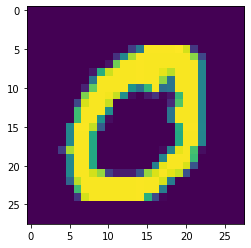

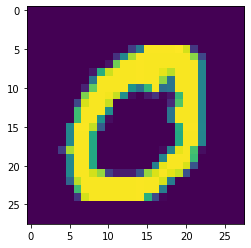

In [10]:
def row_to_matrix(row):
    matrix = []
    k = 0
    one_row = []
    for i in range(len(row)):
        one_row.append(row[i])
        k += 1
        if k == 28:
            k = 0
            matrix.append(one_row)
            one_row = []
    return matrix

fig, ax = plt.subplots()
im = ax.imshow(row_to_matrix(X_t[51]))
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(x_train[51])
plt.show()

In [11]:
print(y_train[5])

Y_t = []

for i in range(n):
    ans_digit = [0,0,0,0,0,0,0,0,0,0]
    ans_digit[y_train[i]] = 1
    Y_t.append(ans_digit)

Y_t = np.array(Y_t)
print(Y_t[5].reshape((len(Y_t[5]),1)))


2
[[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [12]:
model.predict(X_t[666])
print(model.activationsL[1].index(max(model.activationsL[1])))

8


In [13]:
model.predict(X_t[66])
print(model.activationsL[1].index(max(model.activationsL[1])))

8


In [14]:
model.predict(X_t[39])
print(model.activationsL[1].index(max(model.activationsL[1])))

8


In [15]:
model.predict(X_t[481])
print(model.activationsL[1].index(max(model.activationsL[1])))

2


In [16]:
for i in range(1000):
    model.trainOnSingleExample(X_t[i],Y_t[i].reshape((len(Y_t[i]),1)))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [3]:
model.predict(X_t[51])
print(model.activationsL[3].index(max(model.activationsL[3])))

NameError: name 'model' is not defined

In [ ]:
X_test = [] # новый сэт из строк-чисел
for i in range(n):
    digit = x_test[i]
    digit_row = []
    for j in range(28): # 28x28 это размер входа (числа)
        for k in range(28):
            digit_row.append(digit[j][k]/255)
    X_test.append(digit_row)

def row_to_matrix(row):
    matrix = []
    k = 0
    one_row = []
    for i in range(len(row)):
        one_row.append(row[i])
        k += 1
        if k == 28:
            k = 0
            matrix.append(one_row)
            one_row = []
    return matrix


fig, ax = plt.subplots()
im = ax.imshow(x_test[222])
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(row_to_matrix(X_test[222]))
plt.show()